In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib

In [18]:
path_to_data = '../external_data/mixmhcpred/TableS2.txt'
# ignore the first row (header)
df = pd.read_csv(path_to_data, sep='\t', skiprows=1)
df['Peptide_Lengths'] = df['Peptide'].apply(len)

In [19]:
duplicates = df[df.duplicated(subset='Peptide', keep=False)]

In [20]:
duplicates[duplicates['Peptide'] == 'ADMGHLKY']

,Peptide,Allele,Peptide_Lengths
1,ADMGHLKY,A0101,8
112390,ADMGHLKY,A3601,8
189307,ADMGHLKY,B1801,8
257109,ADMGHLKY,B4403,8


In [21]:
df.groupby('Peptide_Lengths')['Peptide'].count()

Peptide_Lengths
8      26284
9     235054
10     64993
11     39118
12     11798
13      4963
14      1860
Name: Peptide, dtype: int64

In [22]:
df['PeptideShortened'] = df['Peptide'].apply(lambda x: x[:4] + x[-4:])

Make sure lengths are equally represented

In [24]:
def limit_rows(group):
    return group.head(10000)

df = df.groupby('Peptide_Lengths').apply(limit_rows).reset_index(drop=True)

In [25]:
allele_counts = df['Allele'].value_counts()
# Create a mask to filter IDs that appear at least 10 times
mask = df['Allele'].map(allele_counts) >= 10
df = df[mask]

In [26]:
encoder = OneHotEncoder()
X_encoded = np.array([list(s) for s in df['PeptideShortened'].values])
X_encoded = encoder.fit_transform(X_encoded).toarray()

label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = label_encoder.fit_transform(df['Allele'].values)

In [83]:
#from sklearn.utils.class_weight import compute_sample_weight
#classes_weights = compute_sample_weight(
#    class_weight='balanced',
#    y=y_labeled
#)

# calc

In [27]:
indices = np.arange(len(X_encoded))
X_train_encoded, X_test_encoded, y_train_labeled, y_test_labeled, indices_train, indices_test, = train_test_split(X_encoded, y_labeled, indices, test_size=0.1, random_state=1)

In [31]:
num_classes = len(np.unique(df['Allele']))
model_all = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    learning_rate=0.2,
    n_estimators=40,
    eval_metric = "mlogloss",
    alpha = 0.005,
)

# Train the model while monitoring the evaluation metrics
model_all.fit(
    X_train_encoded, y_train_labeled,
    eval_set=[(X_train_encoded, y_train_labeled), (X_test_encoded, y_test_labeled)],  # Datasets for evaluation
    verbose=True
)

[0]	validation_0-mlogloss:2.23208	validation_1-mlogloss:2.22509
[1]	validation_0-mlogloss:2.05930	validation_1-mlogloss:2.07763
[2]	validation_0-mlogloss:1.81296	validation_1-mlogloss:1.84983
[3]	validation_0-mlogloss:1.71205	validation_1-mlogloss:1.76091
[4]	validation_0-mlogloss:1.63535	validation_1-mlogloss:1.69724
[5]	validation_0-mlogloss:1.57229	validation_1-mlogloss:1.64649
[6]	validation_0-mlogloss:1.51733	validation_1-mlogloss:1.60177
[7]	validation_0-mlogloss:1.47065	validation_1-mlogloss:1.56492
[8]	validation_0-mlogloss:1.43167	validation_1-mlogloss:1.53638
[9]	validation_0-mlogloss:1.39637	validation_1-mlogloss:1.50939
[10]	validation_0-mlogloss:1.36605	validation_1-mlogloss:1.48686
[11]	validation_0-mlogloss:1.33844	validation_1-mlogloss:1.46802
[12]	validation_0-mlogloss:1.31291	validation_1-mlogloss:1.45012
[13]	validation_0-mlogloss:1.29016	validation_1-mlogloss:1.43473
[14]	validation_0-mlogloss:1.26960	validation_1-mlogloss:1.42136
[15]	validation_0-mlogloss:1.25018	

XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_class=94, ...)

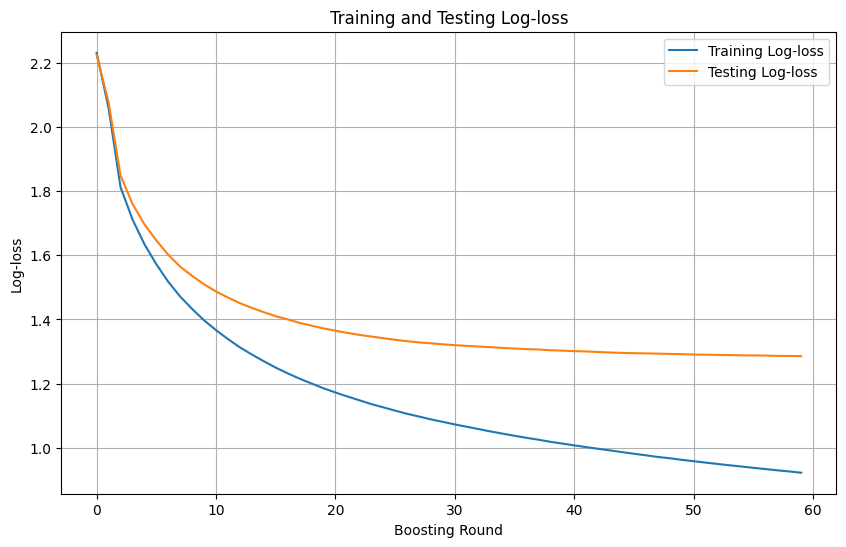

In [29]:
# Get the evaluation results for both training and validation sets
results = model_all.evals_result()

# Extract log-loss values
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

# Plot log-loss
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label="Training Log-loss")
plt.plot(test_logloss, label="Testing Log-loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log-loss")
plt.title("Training and Testing Log-loss")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def save_model_params(feature_encoder, label_encoder, my_model, file_path):
    joblib.dump(my_model, file_path + "_xgboost_model.joblib")
    joblib.dump(feature_encoder, file_path + '_feature_encoder.joblib')
    joblib.dump(label_encoder, file_path + '_label_encoder.joblib')

In [10]:
save_model_params(encoder, label_encoder, model_all,
                  "/Users/halasadi/code/pmhc_methods_tf/internal_data/2023_12_22_all_8mer_xgboost_model")

In [33]:
joblib.dump(indices_test)